# Stan PBS workflow

This notebook documents and reproduces hierarchical model outputs from PBS cluster runs. 

- Sampling was performed with `models/hierarchical_colon_nb_noyrep.stan`, a variant that omits posterior predictive draws (`y_rep`) to minimize output size (the `y_rep` draws were generated later in a separate generate-quantities step).
- Posterior predictive draws (`y_rep`) were produced in a separate generate-quantities pass and stored under `outputs/cmdstan_run/gq_*`.
- To reproduce figures, we load `outputs/stan_summary_full.csv` and the latest GQ CSV, then call `scripts/export_figs.py`.

For the exact commands, see the PBS scripts in `scripts/`.

## PBS run configuration and provenance

- Model (sampling): `models/hierarchical_colon_nb_noyrep.stan` (no y_rep in generated quantities)
- CmdStan/CmdStanPy: CmdStan 2.37.0 via CmdStanPy 1.2.5
- Cluster queue: `v1_throughput72` (1 node, 8 CPUs)
- Job ID: 1664802 (single chain, 8 threads; diag_e metric, adapt_delta=0.985)
- Sampling CSV (archived): `outputs/salvaged/1664802/hierarchical_colon_nb_noyrep-20251107023940.csv`
- Summary CSV: `outputs/stan_summary_full.csv`
- Generated quantities (y_rep): produced separately under `outputs/cmdstan_run/gq_1664802/hierarchical_colon_nb-20251107155530.csv`
- Figure exporter: `scripts/export_figs.py` (reads summary + latest GQ and writes to `outputs/cmdstan_run/gq_1664802/`)
- Diagnose: `outputs/diagnose.txt`

All figures are rendered from the exact CSV artifacts above.

## Model used for cluster sampling (no y_rep)

Below we show the exact Stan program used for sampling on the cluster: `models/hierarchical_colon_nb_noyrep.stan`.
This variant excludes posterior predictive generation during sampling to minimize I/O; GQ is run separately.


In [5]:
# Display Stan model file used for sampling (read-only)
from pathlib import Path
stan_path = Path('..') / 'models' / 'hierarchical_colon_nb_noyrep.stan'
print('Model path:', stan_path.resolve())
try:
    print('\n----- BEGIN STAN -----')
    print(stan_path.read_text(encoding='utf-8'))
    print('----- END STAN -----')
except FileNotFoundError:
    print('Stan file not found. Ensure models/hierarchical_colon_nb_noyrep.stan exists in the repo.')


Model path: /rds/general/user/oohia/home/Early-Onset-Colon-Cancer-Trends-CI5plus/models/hierarchical_colon_nb_noyrep.stan

----- BEGIN STAN -----
functions {
  real partial_sum(array[] int y_slice,
                   int start, int end,
                   vector py,
                   array[] int country_id,
                   matrix B_age,
                   array[] int male,
                   vector year_c,
                   real alpha,
                   vector country_eff,
                   vector beta_age,
                   real beta_male,
                   real beta_year,
                   real phi) {
    real lp = 0;
    for (n in start:end) {
      int k = n - start + 1;
      real eta = alpha
                 + country_eff[country_id[n]]
                 + B_age[n] * beta_age
                 + beta_male * male[n]
                 + beta_year * year_c[n]
                 + log(py[n]);
      lp += neg_binomial_2_log_lpmf(y_slice[k] | eta, phi);
    }
    return lp;
  }
}


## Cluser run artifacts

**Sections:**

- Parameter summaries & IRRs
- Random effects (region, country) IRR excerpts
- Convergence & sampler health (R-hat, ESS, divergences, treedepth)
- Standardized figures (age curve, IRR forest, PPC)
- ArviZ lightweight summary (selected parameters)

No Stan compilation or sampling occurs here; all content derives from existing CSV artifacts. Sampling CSVs, generated-quantities CSVs and summaries liver under `outputs/`


In [ ]:
# Paths and imports (pinned to PBS run 1664802)
from pathlib import Path
import json, re
import numpy as np, pandas as pd
# NOTE: Heavy libraries (matplotlib, arviz, PIL) are imported later only in the cells that need them.

root = Path.cwd().resolve().parent if (Path.cwd().name == 'notebooks') else Path.cwd().resolve()
outs = root / 'outputs'
figs_dir = outs / 'cmdstan_run' / 'gq_1664802'
summary_csv = outs / 'stan_summary_full.csv'
diagnose_txt = outs / 'diagnose.txt'
sampling_csv = outs / 'salvaged' / '1664802' / 'hierarchical_colon_nb_noyrep-20251107023940.csv'

print('Summary CSV:', summary_csv)
print('Diagnose:', diagnose_txt)
print('Sampling CSV (optional for ArviZ):', sampling_csv)
print('Figures dir:', figs_dir)


Summary CSV: /rds/general/user/oohia/home/Early-Onset-Colon-Cancer-Trends-CI5plus/outputs/stan_summary_full.csv
Diagnose: /rds/general/user/oohia/home/Early-Onset-Colon-Cancer-Trends-CI5plus/outputs/diagnose.txt
Sampling CSV (optional for ArviZ): /rds/general/user/oohia/home/Early-Onset-Colon-Cancer-Trends-CI5plus/outputs/salvaged/1664802/hierarchical_colon_nb_noyrep-20251107023940.csv
Figures dir: /rds/general/user/oohia/home/Early-Onset-Colon-Cancer-Trends-CI5plus/outputs/cmdstan_run/gq_1664802


In [7]:
# Load summary
summ = None
if summary_csv.exists():
    summ = pd.read_csv(summary_csv)
    # If parameter names are in index, normalize
    if 'name' not in summ.columns and 'Unnamed: 0' in summ.columns:
        # Keep as-is; later logic supports both
        pass
    print('Loaded summary with shape:', summ.shape)
    display(summ.head())
else:
    print('Summary CSV not found at:', summary_csv)


Loaded summary with shape: (49972, 12)


,Unnamed: 0,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,ESS_bulk/s,R_hat
0,lp__,-66708.000000,0.731870,11.548600,11.494600,-66728.300000,-66707.400000,-66689.400000,248.114,548.912,0.017482,1.00237
1,alpha,-12.030500,0.010008,0.221389,0.215407,-12.386600,-12.035900,-11.662000,478.257,645.290,0.033699,1.00391
2,z_region[1],0.617047,0.016801,0.355497,0.340467,0.033652,0.615308,1.217990,447.465,584.239,0.031529,1.00091
3,z_region[2],-0.159755,0.015119,0.311673,0.323991,-0.670936,-0.141625,0.336879,427.020,738.585,0.030088,1.00404
4,z_region[3],0.827740,0.017493,0.411251,0.429811,0.193292,0.806025,1.542680,559.753,740.860,0.039441,1.00348


In [ ]:
# Compute IRRs for sex and year 
if summ is not None:
    def irr_for(param_name):
        rows = None
        if 'name' in summ.columns:
            rows = summ[summ['name'].astype(str).str.contains(f'^{param_name}$', regex=True)]
        elif 'Unnamed: 0' in summ.columns:
            rows = summ[summ['Unnamed: 0'].astype(str).str.contains(f'^{param_name}$', regex=True)]
        if rows is None or rows.empty:
            print('Param not found:', param_name); return None
        mu = rows['Mean'].values[0] if 'Mean' in rows.columns else rows.get('mean', pd.Series([np.nan])).values[0]
        sd = rows['StdDev'].values[0] if 'StdDev' in rows.columns else rows.get('sd', pd.Series([np.nan])).values[0]
        return {
            'param': param_name,
            'irr_mean': float(np.exp(mu)) if np.isfinite(mu) else np.nan,
            'irr_low95': float(np.exp(mu - 1.96*sd)) if np.isfinite(mu) and np.isfinite(sd) else np.nan,
            'irr_high95': float(np.exp(mu + 1.96*sd)) if np.isfinite(mu) and np.isfinite(sd) else np.nan,
        }
    irr_sex = irr_for('beta_male')
    irr_year = irr_for('beta_year')
    print('IRR(sex=male vs female):', irr_sex)
    print('IRR(per unit year_c):', irr_year)
else:
    print('No summary loaded; skipping IRR computation.')


IRR(sex=male vs female): {'param': 'beta_male', 'irr_mean': 1.7570811591012723, 'irr_low95': 1.7365712444961983, 'irr_high95': 1.777833307705349}
IRR(per unit year_c): {'param': 'beta_year', 'irr_mean': 1.308703562182471, 'irr_low95': 1.2999051335338325, 'irr_high95': 1.31756154313588}


In [10]:
# Random effects IRR table
if summ is not None:
    param_col = 'name' if 'name' in summ.columns else ('Unnamed: 0' if 'Unnamed: 0' in summ.columns else None)
    if param_col:
        eff_rows = summ[summ[param_col].str.contains('^region_eff\[|^country_eff\[', regex=True)]
        if not eff_rows.empty:
            cols = [c for c in ['Mean','StdDev','mean','sd'] if c in eff_rows.columns]
            eff = eff_rows[[param_col] + cols].copy()
            mean_col = 'Mean' if 'Mean' in eff.columns else 'mean'
            sd_col = 'StdDev' if 'StdDev' in eff.columns else ('sd' if 'sd' in eff.columns else None)
            eff['IRR_mean'] = np.exp(eff[mean_col])
            if sd_col:
                eff['IRR_low95'] = np.exp(eff[mean_col] - 1.96*eff[sd_col])
                eff['IRR_high95'] = np.exp(eff[mean_col] + 1.96*eff[sd_col])
            display(eff.head())
        else:
            print('No random-effect rows found.')
    else:
        print('No recognizable parameter name column.')
else:
    print('Summary not loaded; skipping random effects table.')


,Unnamed: 0,Mean,StdDev,IRR_mean,IRR_low95,IRR_high95
135,region_eff[1],0.444458,0.247637,1.559645,0.959915,2.534070
136,region_eff[2],-0.123444,0.238312,0.883871,0.554031,1.410082
137,region_eff[3],0.599062,0.274474,1.820410,1.062998,3.117499
138,region_eff[4],-0.322593,0.239702,0.724269,0.452753,1.158612
139,region_eff[5],0.543773,0.277480,1.722494,0.999912,2.967245


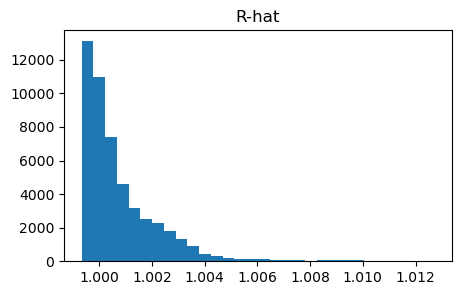

R-hat max: 1.0127
ESS_bulk quantiles: [1214.121 1730.95  2777.288]


In [11]:
# Diagnostics: R-hat distribution and ESS
import matplotlib.pyplot as plt
if summ is not None:
    rhat_col = next((c for c in ['R_hat','r_hat'] if c in summ.columns), None)
    ess_col = next((c for c in ['ESS_bulk','ess_bulk'] if c in summ.columns), None)
    if rhat_col:
        rhats = pd.to_numeric(summ[rhat_col], errors='coerce').dropna().values
        plt.figure(figsize=(5,3)); plt.hist(rhats, bins=30); plt.title('R-hat'); plt.show()
        rhat_max = float(np.nanmax(rhats)) if rhats.size else np.nan
        print('R-hat max:', rhat_max)
    else:
        rhat_max = np.nan
        print('No R-hat column in summary.')
    if ess_col:
        ess_vals = pd.to_numeric(summ[ess_col], errors='coerce').dropna().values
        if ess_vals.size:
            print('ESS_bulk quantiles:', np.nanquantile(ess_vals, [0.05, 0.5, 0.95]))
        else:
            print('ESS values not available.')
else:
    print('No summary to compute diagnostics from.')


In [12]:
# Parse diagnose for divergences and treedepth hits
n_div = np.nan
n_tree = np.nan
if diagnose_txt.exists():
    txt = diagnose_txt.read_text(errors='ignore')
    n_div = sum(1 for _ in re.finditer(r'divergent', txt, re.IGNORECASE))
    n_tree = sum(1 for _ in re.finditer(r'max treedepth', txt, re.IGNORECASE))
    print('Divergences:', n_div, '| Treedepth hits:', n_tree)
    print('First lines:\n', '\n'.join(txt.splitlines()[:25]))
else:
    print('Diagnose file missing:', diagnose_txt)


Divergences: 1 | Treedepth hits: 0
First lines:
 Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.


Using GQ CSV: hierarchical_colon_nb-20251107155530.csv
Detected y_rep columns: 49714
Observed length (92326) != y_rep length (49714); proceeding without PIT.
Draws processed: 1500 | Observations (N): 49714
Observed vs posterior predictive mean (global):
  observed mean: NA (no aligned observed counts)
  y_rep mean (mean over draws, then over obs): 9.257602982392617
Draws processed: 1500 | Observations (N): 49714
Observed vs posterior predictive mean (global):
  observed mean: NA (no aligned observed counts)
  y_rep mean (mean over draws, then over obs): 9.257602982392617


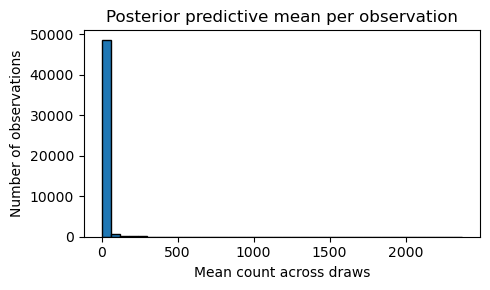

In [ ]:
# Posterior predictive checks (PPC)
# Loads y_rep draws from the generated-quantities CSV and compares to observed counts
# using ECDF overlays and PIT-style histograms.

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 1) Locate GQ CSV under figs_dir (pinned to PBS run 1664802) that contains y_rep columns

def find_yrep_csv_and_cols(search_dir: Path):
    candidates = sorted(list(search_dir.glob('*.csv')))
    for csv_path in candidates:
        # Read header (first non-comment line)
        header = None
        with open(csv_path, 'r', encoding='utf-8', errors='ignore') as f:
            for line in f:
                if line.startswith('#'):
                    continue
                header = [h.strip() for h in line.strip().split(',')]
                break
        if not header:
            continue
        # Identify y_rep columns (robust matching for y_rep[1] or y_rep.1)
        yrep_cols = [h for h in header if h.startswith('y_rep[') or h.startswith('y_rep.')] 
        if yrep_cols:
            return csv_path, yrep_cols
    return None, []

# figs_dir is defined in the earlier paths cell
csv_path, yrep_cols = find_yrep_csv_and_cols(figs_dir)
if not csv_path:
    # As a fallback, check the parent folder too
    csv_path, yrep_cols = find_yrep_csv_and_cols(figs_dir.parent)

if not csv_path:
    print('No GQ CSV with y_rep columns found under', figs_dir)
else:
    print('Using GQ CSV:', csv_path.name)
    print('Detected y_rep columns:', len(yrep_cols))

# 2) Load observed counts vector (cases) if available and aligned
obs_cases = None
obs_source = None
if csv_path:
    # Try known data files in priority order
    for p in [root / 'data' / 'colon_cancer_full_with_nb_preds.csv',
              root / 'data' / 'colon_cancer_full_with_predictions.csv',
              root / 'data' / 'colon_cancer_full.csv']:
        if p.exists():
            try:
                df_obs = pd.read_csv(p, usecols=['cases'])
                obs_cases = df_obs['cases'].to_numpy()
                obs_source = p.name
                break
            except Exception:
                continue

# 3) Stream y_rep to avoid loading entire matrix into memory; compute per-observation
#    predictive mean and PIT-like values relative to observed counts when aligned.

if csv_path:
    N = len(yrep_cols)
    sum_yrep = np.zeros(N, dtype=np.float64)
    cnt_draws = 0
    le_counts = None
    use_pit = False

    if obs_cases is not None and obs_cases.shape[0] == N:
        le_counts = np.zeros(N, dtype=np.int64)
        use_pit = True
    else:
        if obs_cases is None:
            print('Observed counts not found; proceeding without PIT.')
        else:
            print(f'Observed length ({obs_cases.shape[0]}) != y_rep length ({N}); proceeding without PIT.')
            obs_cases = None

    # Stream in chunks over draws
    for chunk in pd.read_csv(csv_path, usecols=yrep_cols, comment='#', chunksize=250, low_memory=False):
        vals = chunk.to_numpy(dtype=np.float64, copy=False)  # shape (chunk_draws, N)
        sum_yrep += np.sum(vals, axis=0)
        if use_pit:
            # Count how many draws are <= observed for each observation
            le_counts += (vals <= obs_cases[None, :]).sum(axis=0)
        cnt_draws += vals.shape[0]

    if cnt_draws == 0:
        print('No draws found in CSV (after skipping comments).')
    else:
        yrep_mean = sum_yrep / float(cnt_draws)
        print(f'Draws processed: {cnt_draws} | Observations (N): {N}')
        print('Observed vs posterior predictive mean (global):')
        if obs_cases is not None:
            print('  observed mean:', float(np.mean(obs_cases)))
        else:
            print('  observed mean: NA (no aligned observed counts)')
        print('  y_rep mean (mean over draws, then over obs):', float(np.mean(yrep_mean)))

        # 4) Plots
        if use_pit:
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            # ECDF overlay: observed cases vs predictive mean per observation
            def ecdf(x):
                x = np.asarray(x)
                xs = np.sort(x)
                ys = np.arange(1, xs.size + 1) / xs.size
                return xs, ys
            x_obs, y_obs = ecdf(obs_cases)
            x_pred, y_pred = ecdf(yrep_mean)
            axes[0].step(x_obs, y_obs, where='post', label='Observed cases', lw=1.5)
            axes[0].step(x_pred, y_pred, where='post', label='Posterior pred. mean', lw=1.5)
            axes[0].set_title('ECDF: observed vs posterior predictive mean')
            axes[0].set_xlabel('Count')
            axes[0].set_ylabel('ECDF')
            axes[0].legend()

            # PIT-style histogram: p_i = P(y_rep <= y_obs | data)
            pit = le_counts / float(cnt_draws)
            axes[1].hist(pit, bins=20, range=(0.0, 1.0), edgecolor='k')
            axes[1].set_title('PIT histogram (uniform if well-specified)')
            axes[1].set_xlabel('P(y_rep <= y_obs)')
            axes[1].set_ylabel('Frequency')
            plt.tight_layout()
            plt.show()
        else:
            # Without aligned observed counts, show the distribution of predictive means
            plt.figure(figsize=(5, 3))
            plt.hist(yrep_mean, bins=40, edgecolor='k')
            plt.title('Posterior predictive mean per observation')
            plt.xlabel('Mean count across draws')
            plt.ylabel('Number of observations')
            plt.tight_layout()
            plt.show()

        # Optional: write a brief text summary
        if obs_cases is not None:
            diff = float(np.mean(yrep_mean) - np.mean(obs_cases))
            print(f'Global mean difference (pred - obs): {diff:.3f}')
        # Done
else:
    print('PPC skipped: no GQ CSV found with y_rep.')

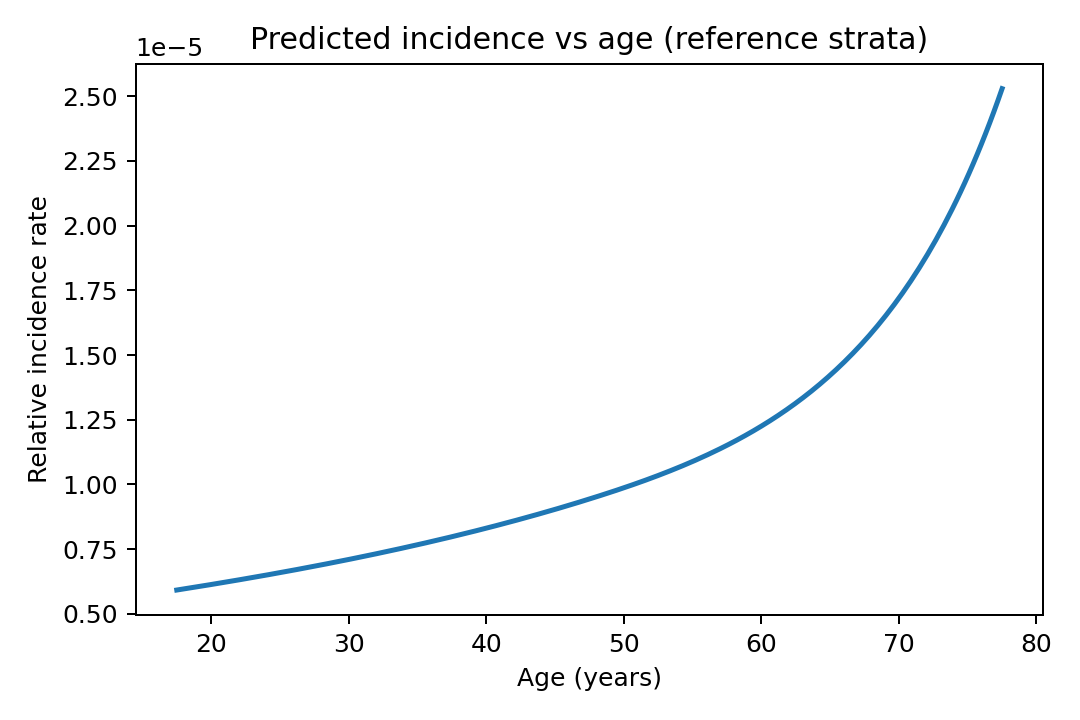

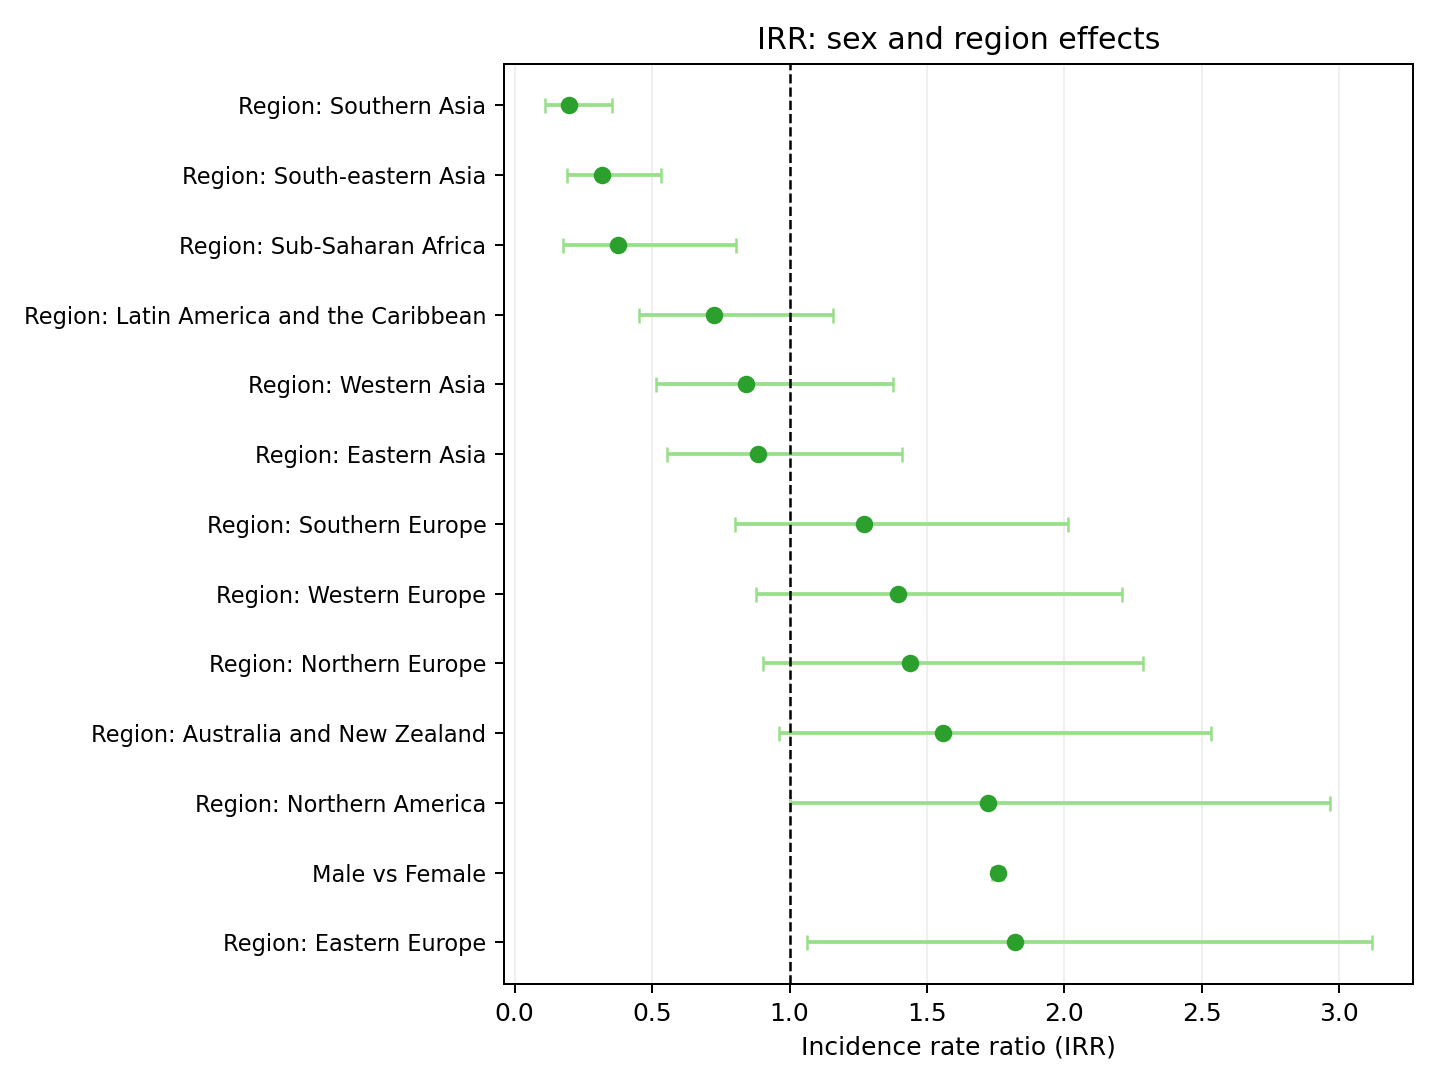

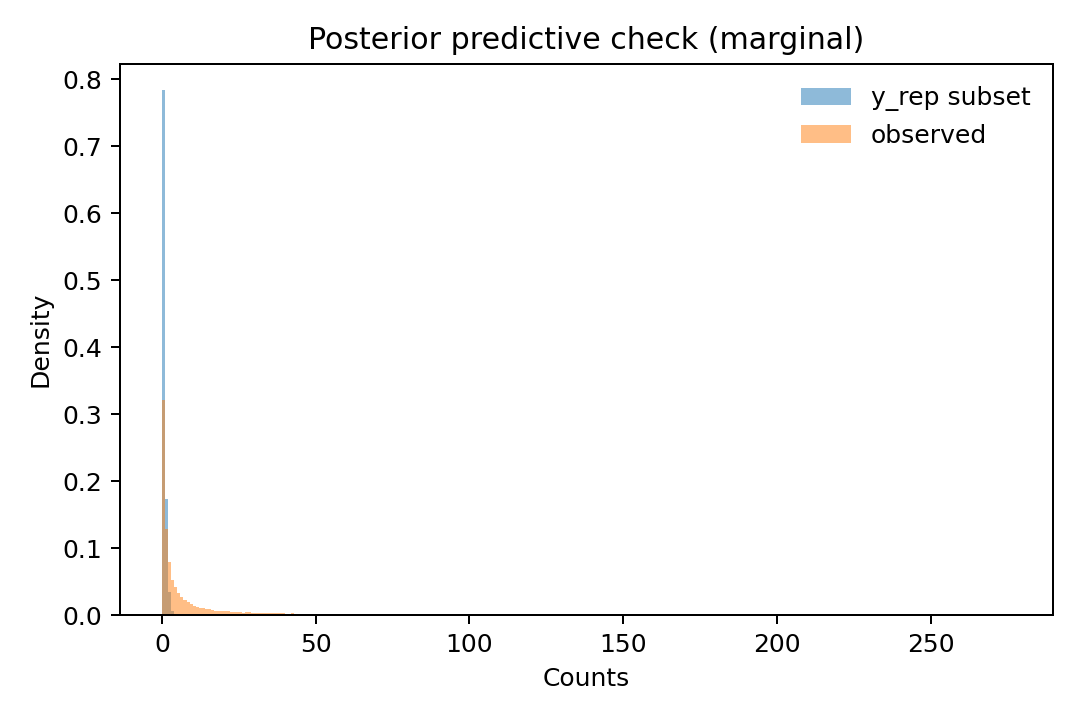

Summary:
  IRR male vs female: 1.757 (95% CI 1.737-1.778)
  IRR per unit year_c: 1.309 (95% CI 1.300-1.318)
  R-hat max: 1.0127
  Divergences: 1 | Treedepth hits: 0


In [16]:
# Display standardized figures (exported by scripts/export_figs.py)
from IPython.display import display, Image
figs = {
    'Age incidence curve': figs_dir / 'age_incidence_curve.png',
    'IRR: sex and region effects': figs_dir / 'irr_forest.png',
    'Posterior predictive check': figs_dir / 'ppc_stan.png',
}
for title, p in figs.items():
    if p.exists():
        display(Image(filename=str(p)))
    else:
        print(f'Missing figure: {p}')

# Simple summary
# Assumes earlier cells defined irr_sex, irr_year, rhat_max, n_div, n_tree

def fmt_irr(d):
    if not d:
        return 'NA'
    return f"{d['irr_mean']:.3f} (95% CI {d['irr_low95']:.3f}-{d['irr_high95']:.3f})"

print('Summary:')
print('  IRR male vs female:', fmt_irr(globals().get('irr_sex')))
print('  IRR per unit year_c:', fmt_irr(globals().get('irr_year')))
print('  R-hat max:', globals().get('rhat_max'))
print('  Divergences:', globals().get('n_div'), '| Treedepth hits:', globals().get('n_tree'))

In [17]:
# ArviZ summary (key parameters only)
try:
    import arviz as az
    if sampling_csv.exists():
        with open(sampling_csv, 'r', encoding='utf-8', errors='ignore') as f:
            header = None
            for line in f:
                if line.startswith('#'):
                    continue
                header = line.strip().split(',')
                break
        usecols = [k for k in ['alpha','beta_male','beta_year'] if header and k in header]
        if usecols:
            draws = pd.read_csv(sampling_csv, usecols=usecols, comment='#')
            posterior = {k: draws[k].to_numpy()[np.newaxis, :, np.newaxis] for k in usecols}
            idata = az.from_dict(posterior=posterior)
            print('\nArviZ summary (selected parameters):')
            display(az.summary(idata))
        else:
            print('ArviZ: selected parameters not found in sampling CSV.')
    else:
        print('ArviZ: sampling CSV not available.')
except ImportError:
    print('ArviZ not installed; skipping.')
except Exception as e:
    print('ArviZ summary failed:', e)


arviz - WARNING - Shape validation failed: input_shape: (1, 1500), minimum_shape: (chains=2, draws=4)



ArviZ summary (selected parameters):


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-12.031,0.221,-12.410,-11.569,0.01,0.007,478.0,645.0,NaN
beta_male[0],0.564,0.006,0.553,0.576,0.00,0.000,1972.0,1154.0,NaN
beta_year[0],0.269,0.003,0.263,0.276,0.00,0.000,3052.0,985.0,NaN
